In [22]:
#imports

import os
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from keras.optimizers import Adam

b)

In [23]:
#function to remove punctuation and numbers from text
def cleantext(text):
    text = re.sub(r'[^\w\s]', '', text)  #remove punctuation
    text = re.sub(r'\d+', '', text)       #remove nums
    return text

#function that reads all files in a folder and returns the texts
def read_files(folder_path):
    file_texts = []
    for file_name in os.listdir(folder_path):   #loop through all files
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r', encoding='utf-8') as file: #open file
            text = file.read()      #read file
            text = cleantext(text)     #cleaning
            file_texts.append(text) #append text
    return file_texts

In [24]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
posFilePath = '/content/drive/My Drive/pos/'
negFilePath = '/content/drive/My Drive/neg/'

#call function to read files
pos = read_files(posFilePath)
neg = read_files(negFilePath)


In [26]:
#set train and test
train_pos = pos[:700]
test_pos = pos[700:1000]
train_neg = neg[:700]
test_neg = neg[700:1000]

In [27]:
#count the number of unique words in the whole dataset (train + test)
total_text = train_pos + test_pos + train_neg + test_neg

#count num unique words
total_texts = ' '.join(total_text)
words = len(set(total_texts.split()))
print("Num unique words:",words)

Num unique words: 47037


In [28]:
#average lengths and standard deviation

review_len = [len(text.split()) for text in total_text]
avg = np.mean(review_len)       #avg
sd = np.std(review_len)         #standard deviation
print("Average length:", avg)
print("Standard deviation of length:", sd)

Average length: 644.3575
Standard deviation of length: 284.98012333099655


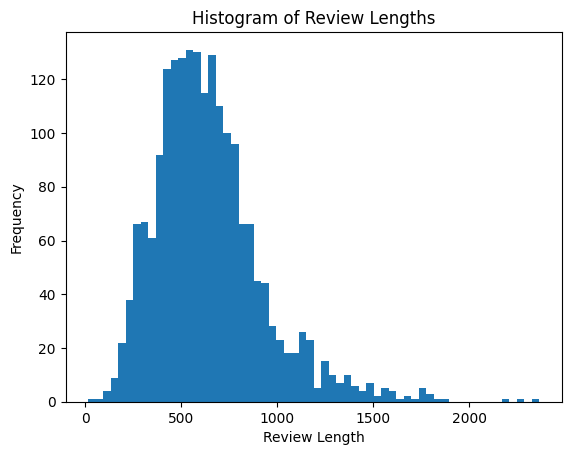

In [29]:
#histogram of lengths
plt.hist(review_len, bins=60)
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Histogram of Review Lengths')
plt.show()

In [30]:
#tokenize using keras
L = int(np.percentile(review_len, 70))

#initialize tokenizer
tokenizer = Tokenizer(num_words = L)

#create train data
train_data = train_pos + train_neg

#fit tokenizer
tokenizer.fit_on_texts(train_data)

#tokenize each doc
tokenized_docs = tokenizer.texts_to_sequences(train_data)

In [31]:
#padded texts
padded_texts = pad_sequences(tokenized_docs, maxlen=L, padding='post', truncating='post')
padded_texts_ = np.array(padded_texts)

In [32]:
#create test data
test_data = test_pos + test_neg

#fit tokenizer
tokenizer.fit_on_texts(test_data)

#tokenize each doc
tokenized_docs = tokenizer.texts_to_sequences(test_data)

#padded test text
padded_texts_test = pad_sequences(tokenized_docs, maxlen=L, padding='post', truncating='post')
padded_texts_test_ = np.array(padded_texts_test)

c)

In [33]:
#source: https://keras.io/api/models/model/
#source: https://keras.io/api/layers/core_layers/embedding/

#initialize model
model = Sequential()

#add embedding layer
model.add(Embedding(input_dim=5000, output_dim=32, input_length=L))

#flatter output
model.add(Flatten())

d)


In [34]:
#first layer
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))

#second layer
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))

#third layer
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))

#output layer
model.add(Dense(1, activation='sigmoid'))

#compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#set y train/test
y_train = np.concatenate((np.ones(len(train_pos)), np.zeros(len(train_neg))))
y_train_ = np.array(y_train)
y_test = np.concatenate((np.ones(len(test_pos)), np.zeros(len(test_neg))))
y_test_ = np.array(y_test)

#fit model
m = model.fit(padded_texts_, y_train_, epochs=2, batch_size=10)

Epoch 1/2
140/140 [==============================] - 4s 19ms/step - loss: 0.6975 - accuracy: 0.5321
Epoch 2/2
140/140 [==============================] - 2s 17ms/step - loss: 0.6889 - accuracy: 0.5157


In [35]:
#source: https://stackoverflow.com/questions/51047676/how-to-get-accuracy-of-model-using-keras

#print accuracies
loss, test_accuracy = model.evaluate(padded_texts_test_, y_test_)
train_accuracy = m.history['accuracy']
print("Train Accuracy:", train_accuracy[-1])
print("Test Accuracy:", test_accuracy)

19/19 [==============================] - 0s 5ms/step - loss: 0.6865 - accuracy: 0.5300
Train Accuracy: 0.5157142877578735
Test Accuracy: 0.5299999713897705


e)

In [36]:
#source: https://keras.io/api/layers/convolution_layers/convolution1d/
#source: https://keras.io/api/layers/pooling_layers/max_pooling1d/

#initialize
model2 = Sequential()

#embedding layer
model2.add(Embedding(input_dim=5000, output_dim=32, input_length=L))

#convulution layer
model2.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

#MaxPooling1D layer
model2.add(MaxPooling1D(pool_size=2, strides=2))

#flatten output
model2.add(Flatten())

#add same layers as before
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

#compile
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#fit model
m2 = model2.fit(padded_texts_, y_train_, epochs=2, batch_size=10)

Epoch 1/2
140/140 [==============================] - 3s 17ms/step - loss: 0.6929 - accuracy: 0.5243
Epoch 2/2
140/140 [==============================] - 4s 30ms/step - loss: 0.5855 - accuracy: 0.7029


In [37]:
#train/test accuracy
loss, test_accuracy = model2.evaluate(padded_texts_test_, y_test_)
train_accuracy = m2.history['accuracy']
print("Train Accuracy:", train_accuracy[-1])
print("Test Accuracy:", test_accuracy)

19/19 [==============================] - 0s 9ms/step - loss: 0.6421 - accuracy: 0.6367
Train Accuracy: 0.7028571367263794
Test Accuracy: 0.6366666555404663


f)

In [38]:
#source: https://keras.io/api/layers/recurrent_layers/lstm/

#initialize
model3 = Sequential()

#embedding layer
model3.add(Embedding(input_dim=5000, output_dim=32, input_length=L))

#LSTM layer
model3.add(LSTM(32, dropout=0.2))

#first layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

#output layer
model.add(Dense(1, activation='sigmoid'))

#compile model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#fit model
m3 = model3.fit(padded_texts_, y_train_, epochs=10, batch_size=10)

Epoch 1/10
140/140 [==============================] - 29s 192ms/step - loss: 3.6515 - accuracy: 0.0157
Epoch 2/10
140/140 [==============================] - 27s 195ms/step - loss: 3.5466 - accuracy: 0.0979
Epoch 3/10
140/140 [==============================] - 28s 198ms/step - loss: 3.5455 - accuracy: 0.1379
Epoch 4/10
140/140 [==============================] - 26s 187ms/step - loss: 3.5451 - accuracy: 0.1036
Epoch 5/10
140/140 [==============================] - 25s 181ms/step - loss: 3.0437 - accuracy: 0.0536
Epoch 6/10
140/140 [==============================] - 27s 191ms/step - loss: 2.8859 - accuracy: 0.1386
Epoch 7/10
140/140 [==============================] - 27s 190ms/step - loss: 2.8841 - accuracy: 0.1450
Epoch 8/10
140/140 [==============================] - 27s 190ms/step - loss: 2.8829 - accuracy: 0.1664
Epoch 9/10
140/140 [==============================] - 26s 188ms/step - loss: 2.8804 - accuracy: 0.1707
Epoch 10/10
140/140 [==============================] - 26s 189ms/step - l

In [39]:
#train/test accuracy
loss, test_accuracy = model3.evaluate(padded_texts_test_, y_test_)
train_accuracy = m3.history['accuracy']
print("Train Accuracy:", train_accuracy[-1])
print("Test Accuracy:", test_accuracy)

19/19 [==============================] - 2s 91ms/step - loss: 2.8868 - accuracy: 0.4867
Train Accuracy: 0.12857143580913544
Test Accuracy: 0.4866666793823242
